# <center> Дипломный проект <br> Прогнозирование временных рядов трафика желтого такси Нью-Йорка

## <center> 1 Предобработка данных

Нью-Йоркская комиссия по такси и лимузинам (TLC) предоставляет подробные анонимизированные данные о поездках клиентов с 2009 года. Машины, выкрашенные жёлтым, имеют право брать пассажиров на улицах в любом из пяти боро города.

Сырые данные о поездках в жёлтом такси можно найти на сайте TLC: www.nyc.gov/html/tlc/html/about/trip_record_data.shtml 

Эти данные разбиты на файлы по месяцам. В каждом из файлов содержится следующая информация о поездках:

- время начала поездки

- время окончания поездки
 
- долгота и широта точки начала поездки

- долгота и широта точки окончания поездки

- количество пассажиров

- расстояние по счётчику

- тип тарифа (одна из шести категорий)

- способ оплаты (одна из шести категорий)

- стоимость поездки по счётчику

- налог на счётчик

- доплата за поездки в пиковые часы и ночью

- доплата за проезд по платным дорогам

- доплата за проезд, взимаемая с каждой поездки с января 2015

- размер чаевых

- общая стоимость поездки

- провайдер данных (одна из двух категорий)

- бинарный флаг, показывающий, были ли данные о поездке получены немедленно после её окончания, или какое-то время - хранились в памяти автомобиля.


сырые данные необходимо агрегировать по часам и районам. Агрегированные данные будут представлять собой почасовые временные ряды с количествами поездок из каждого района.

### Загрузка модулей

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pandas.tseries.offsets import *
from glob import glob
import os
from tqdm import tqdm_notebook

### Загрузка данных

Для примера обработаем данные за май 2016 года

In [2]:
raw_data = pd.read_csv('yellow_tripdata_2016-05.csv', 
                       parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
                       nrows=10000)
raw_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [3]:
print(raw_data.shape)

(10000, 19)


За май 2016 года было совершенно ... поездок.

In [4]:
raw_data = raw_data[['tpep_pickup_datetime','tpep_dropoff_datetime',
          'passenger_count','trip_distance',
          'pickup_longitude', 'pickup_latitude']]

### Фильтрация данных

Очистим данные от бесполезных поездок и за пределами города Нью-Йорка:

In [3]:
# Координаты Нью-Йорка
# Долгота
xmin = -74.25559
xmax = -73.70001
# Широта
ymin = 40.49612
ymax = 40.91553

In [ ]:
raw_data = raw_data[
        (raw_data['tpep_dropoff_datetime'] != raw_data['tpep_pickup_datetime']) & 
        (raw_data['passenger_count'] != 0) & # поездки без пассажиров
        (raw_data['trip_distance'] != 0) & # поездки с нулевым расстоянием по счетчику
        (raw_data['pickup_longitude'] >= xmin) & #поездки за пределами города
        (raw_data['pickup_longitude'] <= xmax) &
        (raw_data['pickup_latitude'] >= ymin) &
        (raw_data['pickup_latitude'] <= ymax)]

In [4]:
raw_data.shape

(9816, 6)

### Агрегирование количество поездок по часам и регионам

В соответствии с заданием прогнозировать трафик необходимо по часам и по регионам.
Для этого разобьем карту Нью-Йорка на 2500 ячеек и подсчитаем количество поездок в каждом регионе по часам:

In [10]:
# Удаляем секунды и минуты
raw_data['tpep_pickup_datetime'] = raw_data['tpep_pickup_datetime'] - \
pd.to_timedelta(raw_data.tpep_pickup_datetime.dt.second, unit='s') - \
pd.to_timedelta(raw_data.tpep_pickup_datetime.dt.minute, unit='m')

In [2]:
# функция определяет номер ячейки в зависимости от координат начала поездки
def region(x,y):
    rev = stats.binned_statistic_2d(x, y, None, statistic='count', bins=50, 
                                    range=[[xmin, xmax], [ymin, ymax]],expand_binnumbers=True)
    return rev.binnumber[0] * 50 - (50 - rev.binnumber[1])

In [12]:
# Добавляем регионы
raw_data['region'] = region(raw_data['pickup_longitude'].values,raw_data['pickup_latitude'].values)

In [13]:
# Группируем и подсчитываем количество элементов в группах
group = raw_data.groupby(by=['tpep_pickup_datetime','region'], as_index=False).count()

In [14]:
grouped = group.iloc[:,:3]

In [15]:
# Создаем пустой месяц по всем регионам
month = []
for t in pd.date_range(start='2016-05',end='2016-06',freq='H',closed='left'):
    for i in range(1,2501):
        month.append([t,i,0])
month = pd.DataFrame(month, columns=['tpep_pickup_datetime','region','VendorID'])

In [16]:
# Добавляем пустые часы / регионы
train_data = pd.DataFrame(pd.merge(grouped,month,on=['tpep_pickup_datetime','region'],how='right').iloc[:,:3].fillna(0).values,
                         columns=['time','region','count'])

### График количества поездок жёлтого такси из ячейки, содержащей Empire State Building

In [6]:
region([-73.985428],[40.748817])

/home/vadim/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


array([1231])

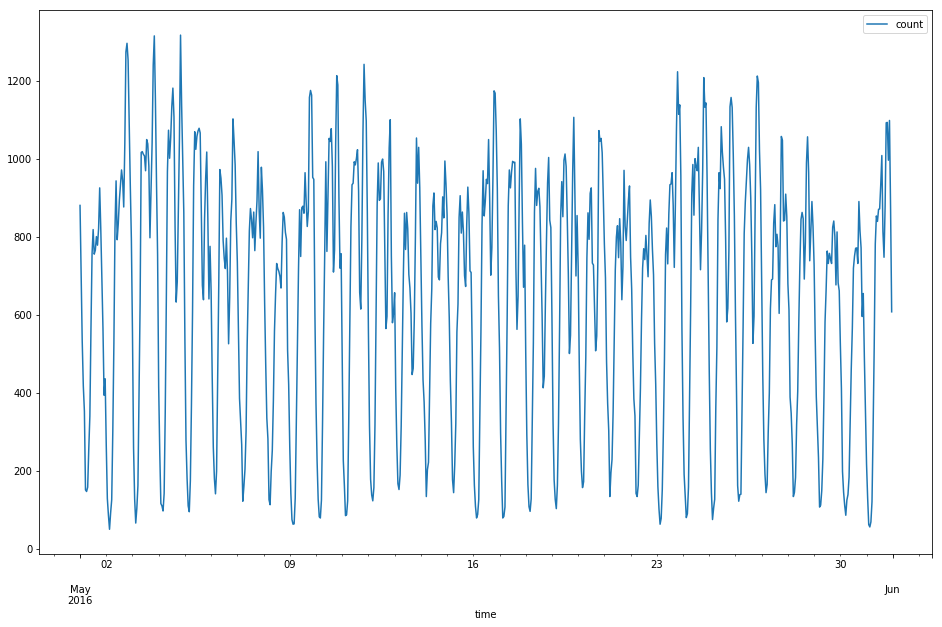

In [18]:
# Координаты Empire State Building 40.748817, -73.985428
Empire = train_data[train_data['region'] == int(region([-73.985428],[40.748817]))]
Empire.plot('time','count',figsize=(16,10))

In [19]:
print('Количество пар час-ячейка, для которых не было совершено ни одной поездки: {}'.format((train_data['count'] == 0).value_counts()[1]))

Количество пар час-ячейка, для которых не было совершено ни одной поездки: 1718238


### Обработка всех данных

Теперь обработаем все имеющиеся данные с 2013 до 2016 и сохраним в csv:

In [5]:
def prepare_train_set(path_to_csv_files):
    path_files_list = glob(os.path.join(path_to_csv_files, 'yellow_tripdata*.csv'))    
    for path_file in tqdm_notebook(path_files_list):
        prepare_file(path_file)

In [4]:
def prepare_file(path_file):
    date_month = pd.to_datetime(path_file[-11:-4])    
    raw_data = pd.read_csv(path_file, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
    # Долгота
    xmin = -74.25559
    xmax = -73.70001
    # Широта
    ymin = 40.49612
    ymax = 40.91553

    raw_data = raw_data[['tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count','trip_distance',
          'pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude']]
    
    raw_data = raw_data[
        (raw_data['tpep_dropoff_datetime'] != raw_data['tpep_pickup_datetime']) & 
        (raw_data['passenger_count'] != 0) &
        (raw_data['trip_distance'] != 0) &
        (raw_data['pickup_longitude'] >= xmin) &
        (raw_data['pickup_longitude'] <= xmax) &
        (raw_data['pickup_latitude'] >= ymin) &
        (raw_data['pickup_latitude'] <= ymax)]
    # Удаляем секунды и минуты
    raw_data['tpep_pickup_datetime'] = raw_data['tpep_pickup_datetime'] - \
    pd.to_timedelta(raw_data.tpep_pickup_datetime.dt.second, unit='s') - \
    pd.to_timedelta(raw_data.tpep_pickup_datetime.dt.minute, unit='m')
    raw_data['tpep_dropoff_datetime'] = raw_data['tpep_dropoff_datetime'] - \
    pd.to_timedelta(raw_data.tpep_dropoff_datetime.dt.second, unit='s') - \
    pd.to_timedelta(raw_data.tpep_dropoff_datetime.dt.minute, unit='m')
    
    # Добавляем регион
    raw_data['region'] = region(raw_data['pickup_longitude'].values,raw_data['pickup_latitude'].values)
    # Группируем и подсчитываем количество элементов в группах
    group = raw_data.groupby(by=['tpep_pickup_datetime','region'], as_index=False).count()
    grouped = group.iloc[:,:3]
    
    # Создаем пустой месяц по всем регионам
    month = []
    for t in pd.date_range(start=date_month, end=date_month + DateOffset(months=1),freq='H',closed='left'):
        for i in range(1,2501):
            month.append([t,i,0])
    month = pd.DataFrame(month, columns=['tpep_pickup_datetime','region','VendorID'])
    
    train_data = pd.DataFrame(
        pd.merge(grouped,
                 month,on=['tpep_pickup_datetime','region'],how='right').iloc[:,:3].fillna(0).values,
        columns=['time','region','count'])
    train_data.to_csv(path_or_buf = 'train_data_' + date_month.strftime("%Y-%m") + '.csv', index=False)

In [ ]:
prepare_train_set('D:\\Traffic Data\\2013')
prepare_train_set('D:\\Traffic Data\\2014')
prepare_train_set('D:\\Traffic Data\\2015')
prepare_train_set('D:\\Traffic Data\\2016')